<a href="https://colab.research.google.com/github/aliaghababaee/SLO_Asieh/blob/main/VGG_%2B_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)

In [6]:
import tensorflow as tf
from keras.layers import Input
import numpy as np
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import ConfusionMatrixDisplay

In [7]:
!unzip /content/drive/MyDrive/train_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/train_thickness_retina_iran.zip
 extracting: train_labels.pkl        
 extracting: train_thickness_retina.pkl  
 extracting: train_sp.pkl            


In [8]:
!unzip /content/drive/MyDrive/test_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/test_thickness_retina_iran.zip
 extracting: test_labels.pkl         
 extracting: test_thickness_retina.pkl  
 extracting: test_sp.pkl             


In [9]:
!unzip /content/drive/MyDrive/train_SLO_iran.zip

Archive:  /content/drive/MyDrive/train_SLO_iran.zip
 extracting: train_slo_iran.pkl      
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_iran.pkl       


In [10]:
!unzip /content/drive/MyDrive/test_SLO_iran.zip

Archive:  /content/drive/MyDrive/test_SLO_iran.zip
 extracting: test_slo_iran.pkl       
 extracting: test_labels_Iran.pkl    
 extracting: test_sp_iran.pkl        


# Typical Run

In [11]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)

In [12]:
import tensorflow as tf
from keras.layers import Input
import numpy as np
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import ConfusionMatrixDisplay

In [13]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_1 (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)


    datagen = ImageDataGenerator(
    rotation_range= 5, # rotation
    zoom_range = 0.1,
    fill_mode='nearest',
    data_format='channels_last',
      )


    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    return batch, batch_label

In [14]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_2 (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)

    datagen = ImageDataGenerator(
        rotation_range= 10, # rotation
        width_shift_range= [-30, 30], # horizontal shift
        #height_shift_range= [-5, 5] , # vertical shift
        zoom_range= 0.2,
        vertical_flip= True , # vertical flip
        #brightness_range= [0.2, 1.5],
          )

    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    ###################################################################
    # Final data
    ###################################################################

    x = np.concatenate([x_train,batch])

    labels = np.concatenate([labels_train,batch_label])

    ############################

    ############################
    return x, labels

In [16]:
from skimage.transform import resize

In [23]:
import numpy as np
def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):

            data.append(np.array(x[i][j] * 255))
            label.append(y[i])

            #img = resize (x[i][j], (224, 224, 1), mode = 'constant', preserve_range= True)
            #data.append(img)
            #label.append(y[i])

    data = np.reshape(data, np.shape(data))
    return data, np.array(label)

(296, 60, 256, 3)

In [17]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
from sklearn import metrics
import sklearn

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

def metrics_calculation(y_valid, y_pred, y_prob):

    #####################################################
    #Get the confusion matrix
    #####################################################
    ROC_AUC = roc_auc_score(y_valid, y_prob)
    f1 = metrics.f1_score(y_valid, y_pred, average='weighted')
    precision, recall, thresholds = precision_recall_curve(y_valid, y_prob)
    P_R_AUC = auc(recall, precision)
    cm = sklearn.metrics.confusion_matrix(y_valid, y_pred, normalize='pred')
    #Now the normalize the diagonal entries
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_acc = cm.diagonal()

    Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    Sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    Precision   = cm[1,1]/(cm[0,1]+cm[1,1])


    return Specificity, Sensitivity, Precision, f1, ROC_AUC, P_R_AUC, class_acc, cm

In [18]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

def curve_ploting(ax, axx, mean_fpr, aucs, tprs, y_test, y_pred, classifier, kernel=[]):

    ###################### Continuing Ploting ROC curve for each fold and the mean ############

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )

    if kernel:
        ax.set_title(f"ROC Curve of {classifier} classifier ({kernel} kernel) ")
    else:
        ax.set_title(f"ROC Curve of {classifier} classifier")
    ax.legend(loc="lower right")

    ###################### Continuing Ploting P_R_curve for each fold and the mean ############
    ###

    no_skill = len(np.array(y_test)[np.array(y_test)==1]) / len(np.array(y_test))

    axx.plot([0, 1], [no_skill, no_skill], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    axx.plot(
        recall,
        precision,
        color="b",
        label=r"Mean P_R curve (AUC =  %0.2f)" % (auc(recall, precision)),
        lw=2,
        alpha=0.8,
    )


    # axis labels
    axx.set_xlabel('Recall')
    axx.set_ylabel('Precision')
    # show the legend
    axx.legend(loc="lower left")
    if kernel:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier ({kernel} kernel)')
    else:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier')

In [19]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import numpy as np

def fold_curves(ax, axx, y_valid, fold_number, mean_fpr, pred_proba, tprs=[], aucs=[]):
    ############ ROC Curve
    lr_fpr, lr_tpr, _ = roc_curve(y_valid, pred_proba)
    roc_auc = roc_auc_score(y_valid, pred_proba)
    ax.plot(lr_fpr, lr_tpr, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, roc_auc))
    # axis labels
    ax.set_xlabel('False Positive Rate (Positive label: 1.0)')
    ax.set_ylabel('True Positive Rate (Positive label: 1.0)')

    interp_tpr = np.interp(mean_fpr, lr_fpr, lr_tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)


    ############ P_R Curve
    precision, recall, _ = precision_recall_curve(y_valid, pred_proba)
    # plot the model precision-recall curve
    axx.plot(recall, precision, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, auc(recall, precision)))

    return tprs, aucs

In [ ]:
number_class=2
cnn_accc_5iteration=[]
cnn_spp_5iteration=[]
cnn_see_5iteration=[]
cnn_prr_5iteration=[]
cnn_f11_5iteration=[]
cnn_aucc_5iteration=[]
cnn_pr_aucc_5iteration=[]
class_acc_5iteration = np.zeros((5,number_class))


test_accc_5iteration=[]
test_spp_5iteration=[]
test_see_5iteration=[]
test_prr_5iteration=[]
test_f11_5iteration=[]
test_aucc_5iteration=[]
test_pr_aucc_5iteration=[]
class_acc_test_5iteration = np.zeros((5,number_class))
n_iter=0

In [ ]:
x_train.shape

(304, 60, 256, 3)

vgg16

In [20]:
#feature extractor for vgg16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3),
        )


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())
    model.add(Dense(1185, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1160, activation='relu'))
    model.add(Dropout(0.0))
    model.add(Dense(622, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3692, activation='relu'))
    model.add(Dropout(0.7))
    ##################################
    #################################  EFFECT OF Hidden NEURONS  ###################
    model.add(Dense(3544, activation='relu'))
    model.add(Dense((n_class-1), activation='sigmoid'))
    return model


resnet101 with 255

In [17]:
#feature extractor for vgg16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())

    model.add (Dense (482, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add (Dense (4019, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(332, activation='relu'))
    model.add(Dropout(0.6))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.7))
    ##################################
    #################################  EFFECT OF Hidden NEURONS  ###################
    #model.add(Dense(3544, activation='relu'))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


Resnet101 without 255

In [17]:
#Resnet101 without 255


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())


    model.add (Dense (2335, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


resnet 50

In [39]:
#Resnet101 without 255


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())


    model.add (Dense (102, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


custom CNN

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(n_filters=32, n_class=2):


    model = Sequential ()
    input_img = Input((60, 256, 1))
    model.add (Conv2D (n_filters, kernel_size = 3, activation='relu',input_shape=input_img.shape[1:], padding='same'))
    model.add (MaxPool2D (2, 2))
    model.add (BatchNormalization ())

    model.add (Conv2D (n_filters * 2, kernel_size = 3, activation='relu', padding='same'))
    model.add (MaxPool2D (2, 2))
    model.add (BatchNormalization ())




    model.add(Flatten())

    model.add(Dense(32000, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(n_class-1, activation='sigmoid'))
    return model

In [ ]:
plt.imshow (x_train [270,:,:,0], cmap = 'jet')

In [22]:
model.summary ()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2, 8, 2048)        42658176  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_16 (Dense)            (None, 482)               15794658  
                                                                 
 dropout_12 (Dropout)        (None, 482)               0         
                                                                 
 dense_17 (Dense)            (None, 4019)              1941177   
                                                                 
 dropout_13 (Dropout)        (None, 4019)              0         
                                                                 
 dense_18 (Dense)            (None, 332)              

In [ ]:
images_test.shape

In [ ]:
model = cnn_feature_extractor ()

---------------------------------------------------------------------          
 			 1th fold 
---------------------------------------------------------------------




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 8, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_30 (Dense)            (None, 1185)              4854945   
                                                                 
 dropout_20 (Dropout)        (None, 1185)              0         
                                                                 
 dense_31 (Dense)            (None, 1160)              1375760   
                                                                 
 dropout_21 (Dropout)        (None, 1160)              0         
                                                                 
 dense_32 (Dense)            (None, 622)              

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 8, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 4096)              0         
                                                                 
 dense_36 (Dense)            (None, 1185)              4854945   
                                                                 
 dropout_24 (Dropout)        (None, 1185)              0         
                                                                 
 dense_37 (Dense)            (None, 1160)              1375760   
                                                                 
 dropout_25 (Dropout)        (None, 1160)              0         
                                                                 
 dense_38 (Dense)            (None, 622)              

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 8, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 4096)              0         
                                                                 
 dense_42 (Dense)            (None, 1185)              4854945   
                                                                 
 dropout_28 (Dropout)        (None, 1185)              0         
                                                                 
 dense_43 (Dense)            (None, 1160)              1375760   
                                                                 
 dropout_29 (Dropout)        (None, 1160)              0         
                                                                 
 dense_44 (Dense)            (None, 622)              

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 8, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 4096)              0         
                                                                 
 dense_48 (Dense)            (None, 1185)              4854945   
                                                                 
 dropout_32 (Dropout)        (None, 1185)              0         
                                                                 
 dense_49 (Dense)            (None, 1160)              1375760   
                                                                 
 dropout_33 (Dropout)        (None, 1160)              0         
                                                                 
 dense_50 (Dense)            (None, 622)              

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 8, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 4096)              0         
                                                                 
 dense_54 (Dense)            (None, 1185)              4854945   
                                                                 
 dropout_36 (Dropout)        (None, 1185)              0         
                                                                 
 dense_55 (Dense)            (None, 1160)              1375760   
                                                                 
 dropout_37 (Dropout)        (None, 1160)              0         
                                                                 
 dense_56 (Dense)            (None, 622)              

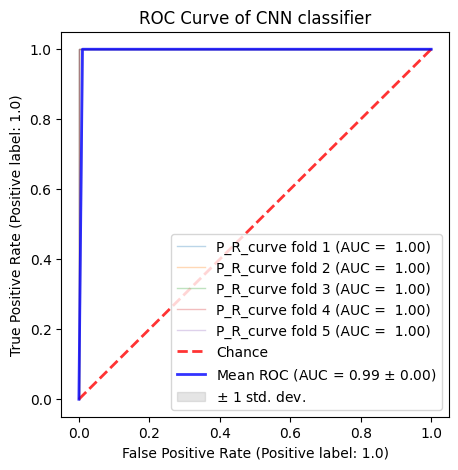

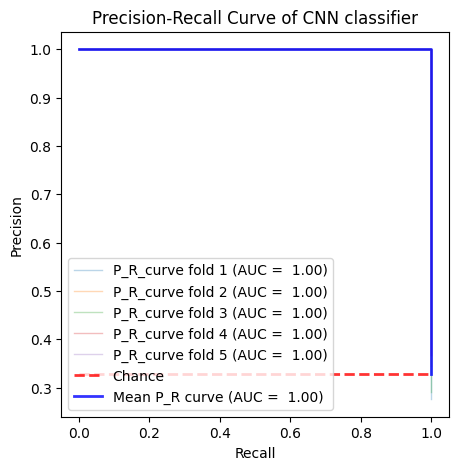

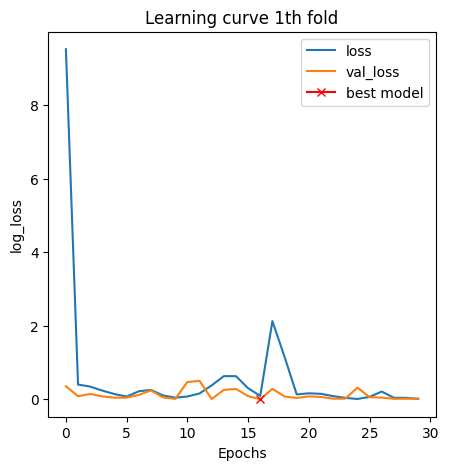

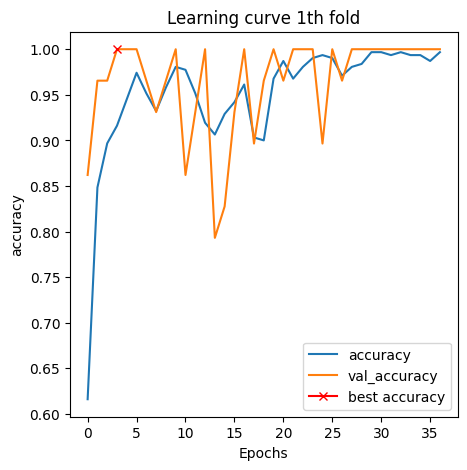

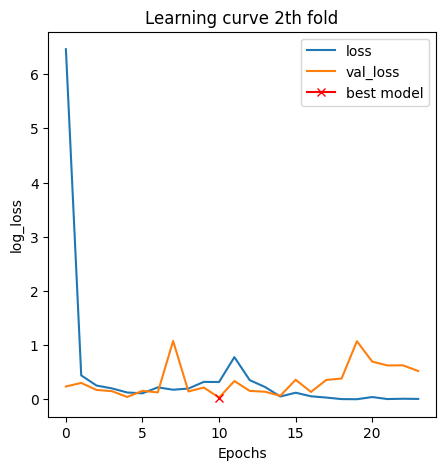

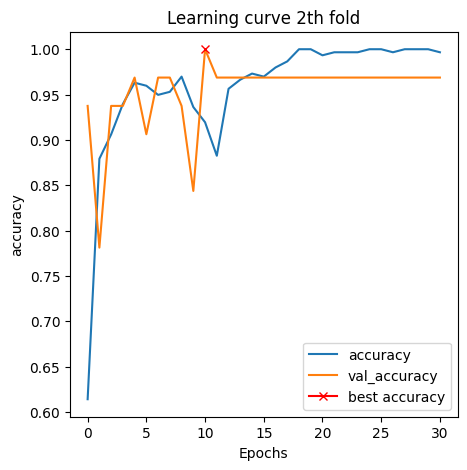

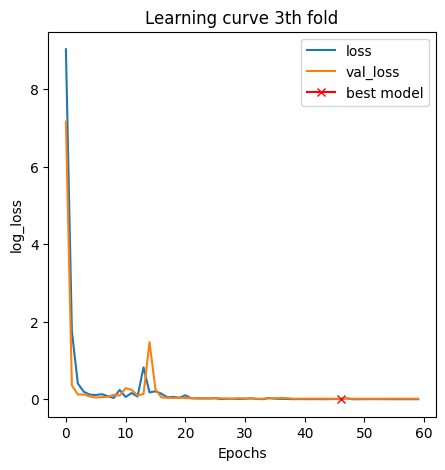

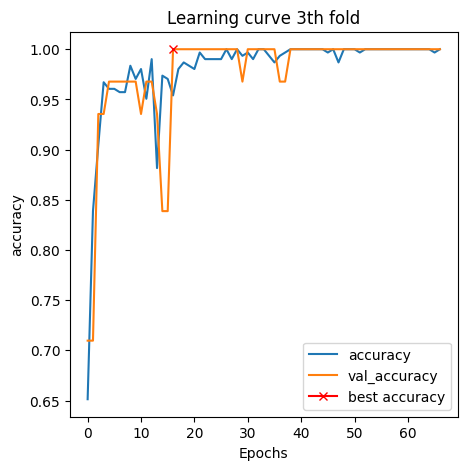

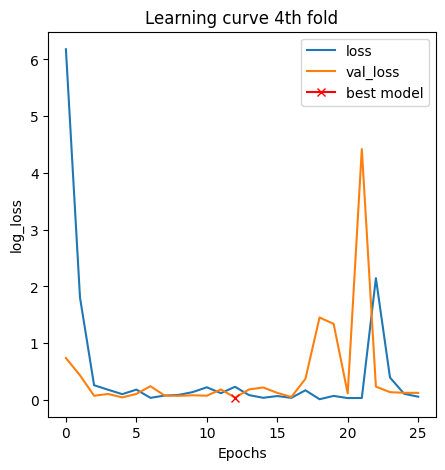

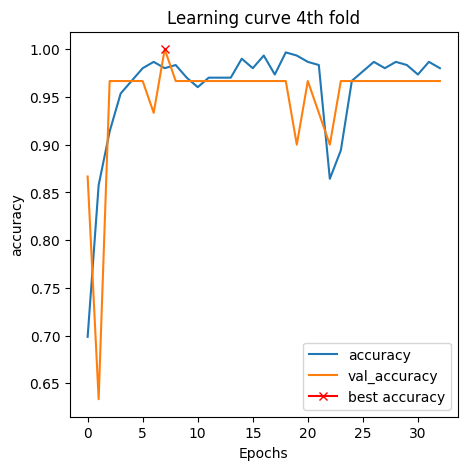

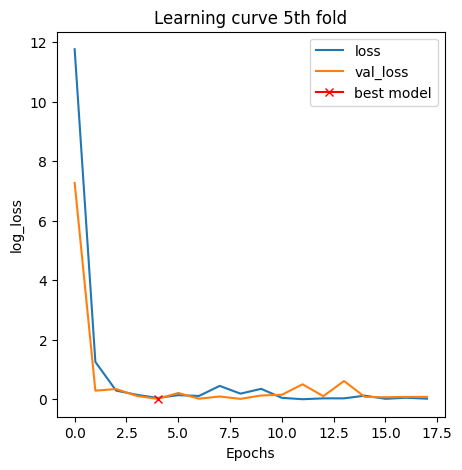

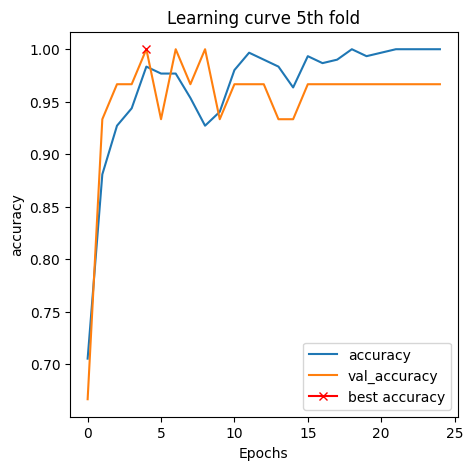

cnn_acc     = 0.993333
cnn_sp      = 0.984615
cnn_se      = 1.000000
cnn_pr      = 0.985714
cnn_f1      = 0.993388
cnn_auc     = 1.000000
cnn_pr_auc  = 1.000000

acc of class Normal = 0.984615
acc of class MS = 1.000000

test_acc     = 0.926316
test_sp      = 0.901659
test_se      = 0.961857
test_pr      = 0.911540
test_f1      = 0.926412
test_auc     = 0.985119
test_pr_auc  = 0.976234

test acc of class Normal = 0.901659
test acc of class MS = 0.961857



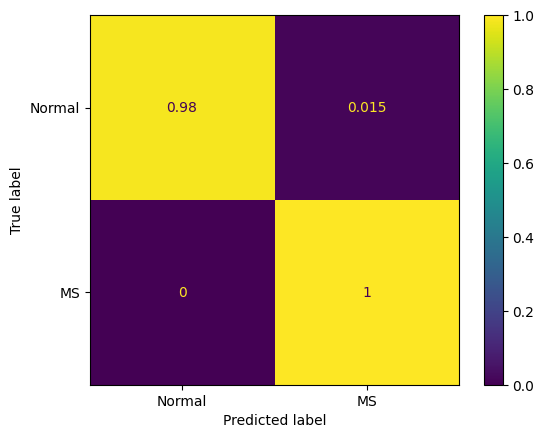

In [24]:
images_train = pickle.load(open("/content/" + "train_thickness_retina.pkl", 'rb'))
labels_train = pickle.load(open("/content/" +"train_labels.pkl", 'rb'))

images_test = pickle.load(open("/content/drive/MyDrive/" +"test_thickness_new.pkl", 'rb'))
labels_test = pickle.load(open("/content/" +"test_labels.pkl", 'rb'))
images_test,labels_test = preparing(images_test,labels_test)

images_test = np.repeat (images_test, repeats = 3, axis = 3)
#####################################################################
## Parameters
#####################################################################
channel = 3
number_class = 2

cnn_acc    = []
cnn_se     = []
cnn_sp     = []
cnn_pr     = []
cnn_f1     = []
cnn_auc    = []
cnn_pr_auc = []

test_acc    = []
test_se     = []
test_sp     = []
test_pr     = []
test_f1     = []
test_auc    = []
test_pr_auc = []


class_acc = np.zeros((number_class))
class_acc_test = np.zeros((number_class))

target_names = ['Normal' , 'MS']
confusion_matrix = np.zeros((number_class, number_class))
confusion_matrix_test = np.zeros((number_class, number_class))

y_test = []
tprs   = []
aucs   = []
y_pred = []
x_test = {}

mean_fpr  = np.linspace(0, 1, 100)
fig, ax   = plt.subplots(figsize=(5, 5))
fig1, ax1 = plt.subplots(figsize=(5, 5))


#### model parameters for vgg
batch_size_vgg    = 8
epoch         = 100
filter_num    = 32
learning_rate_vgg =  0.0004036650839061106




#### model parameters for res101 with 255
batch_size_res255    = 64
epoch         = 100
filter_num    = 32
learning_rate_res255 =  0.0003720165816110892


#### model parameters for res101 without 255
batch_size_res    = 32
epoch         = 100
filter_num    = 32
learning_rate_res =  0.008509082186113752


#### model parameters for res50 with 255
batch_size_res50    = 16
epoch         = 100
filter_num    = 32
learning_rate_res50 =  0.002658420292718515


#### model parameters for cnn
batch_size_cnn    = 8
epoch         = 100
filter_num    = 32
learning_rate_cnn =  0.0005522789895942119

#####################################################################
## Applying kfold
#####################################################################

nfold = 5  #please enter number of folds

kf_nfold = StratifiedKFold(n_splits=nfold, random_state=None, shuffle=True)

n = 0
for train_index, val_index in kf_nfold.split(images_train,list(labels_train.values())):
    n = n+1
    # print(train_index, val_index)  # you can watch train and validation index using this comment
    print(f'---------------------------------------------------------------------\
          \n \t\t\t {n}th fold \n---------------------------------------------------------------------'\
          ,end = '\n\n\n' )
    train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

    x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

    x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

    y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

    y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

    x_train,y_train = preparing(x_train,y_train)

    x_valid,y_valid = preparing(x_valid,y_valid)

    #x_test[n] = x_valid
    ################# Augmentation

    indices = np.where(y_train == 1)[0]

    x_train_ms = x_train[indices]
    y_train_ms = y_train[indices]

    x_train_ms_aug,y_train_ms_aug = Augmentation_1(x_train_ms,y_train_ms)

    x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
    y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

    indices = np.random.permutation (len (x_train))

    x_train_shuf = x_train [indices]
    y_train_shuf = y_train [indices]

    x_train,y_train = Augmentation_2(x_train_shuf,y_train_shuf)

    indices = np.random.permutation (len (x_train))

    x_train = x_train [indices]
    y_train = y_train [indices]

    x_train = np.repeat (x_train, repeats = 3, axis = 3)

    x_valid = np.repeat (x_valid, repeats = 3, axis = 3)

    ####################################################################
    # classification
    ####################################################################

    input_img = Input((np.shape(x_train)[1], np.shape(x_train)[2], channel))

    model = cnn_feature_extractor(input_img)


    METRICS = [
#      keras.metrics.TruePositives(name='tp'),
#      keras.metrics.FalsePositives(name='fp'),
#      keras.metrics.TrueNegatives(name='tn'),
#      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
#      keras.metrics.Precision(name='precision'),
#      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
#      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      ]


    my_optimizer =  tf.keras.optimizers.Adam(lr=learning_rate_vgg)
    model.compile(optimizer=my_optimizer, loss="binary_crossentropy", metrics=METRICS)
    callbacks = [EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
        ModelCheckpoint(f'oct{n}.h5', verbose=1, save_best_only=True, save_weights_only=True)]

    model.summary()

    #################################
    ###### Applying model  ###########
    #################################
    results = model.fit(x_train, y_train, batch_size=batch_size_vgg, epochs=epoch, callbacks=callbacks,\
                    validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)))


    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["loss"][:-7], label="loss")
    plt.plot(results.history["val_loss"][:-7], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["accuracy"], label="accuracy")
    plt.plot(results.history["val_accuracy"], label="val_accuracy")
    plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]),\
             marker="x", color="r", label="best accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()


    # load the best model
    model.load_weights(f'oct{n}.h5')


    pred_proba = model.predict(x_valid).ravel()
    pred_class = (pred_proba > 0.5).astype(np.uint8)


    ##### calculating metrics

    cnn_acc.append(metrics.accuracy_score(y_valid, pred_class))
    print(f'accuracy of {n}th fold : {metrics.accuracy_score(y_valid, pred_class)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(y_valid, pred_class, pred_proba)

    cnn_sp.append(SP)
    cnn_se.append(SE)
    cnn_pr.append(PR)
    cnn_f1.append(f1)
    cnn_auc.append(ROC_AUC)
    cnn_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc  = np.add(class_acc,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix = np.add(confusion_matrix,cm)

######################## internal test
    pred_proba_test = model.predict(images_test).ravel()
    pred_class_test = (pred_proba_test > 0.5).astype(np.uint8)


    ##### calculating metrics
    print(f'test accuracy of {n}th fold : {metrics.accuracy_score(labels_test, pred_class_test)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(labels_test, pred_class_test, pred_proba_test)

    test_acc.append(metrics.accuracy_score(labels_test, pred_class_test))
    test_sp.append(SP)
    test_se.append(SE)
    test_pr.append(PR)
    test_f1.append(f1)
    test_auc.append(ROC_AUC)
    test_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc_test  = np.add(class_acc_test,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix_test = np.add(confusion_matrix_test,cm)

    ###################### Ploting ROC and PR curves for each fold ############
    y_test = np.append(y_test, y_valid, axis = 0)
    y_pred = np.append(y_pred, pred_proba, axis = 0)
    ###
    tprs, aucs = fold_curves(ax, ax1, y_valid, n, mean_fpr, pred_proba, tprs, aucs)

######################  the mean Ploting ROC and PR curves ############
###
curve_ploting(ax, ax1, mean_fpr, aucs, tprs, y_test, y_pred, 'CNN' )

plt.show()

#######################################
    # ploting confusion matrix
#######################################
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix/nfold, display_labels=target_names)
disp.plot()


########################################
#     Metrics printing
########################################
cnn_accc     = np.mean(cnn_acc)
cnn_spp      = np.mean(cnn_sp)
cnn_see      = np.mean(cnn_se)
cnn_prr      = np.mean(cnn_pr)
cnn_f11      = np.mean(cnn_f1)
cnn_aucc     = np.mean(cnn_auc)
cnn_pr_aucc  = np.mean(cnn_pr_auc)

###################### internal test
test_accc     = np.mean(test_acc)
test_spp      = np.mean(test_sp)
test_see      = np.mean(test_se)
test_prr      = np.mean(test_pr)
test_f11      = np.mean(test_f1)
test_aucc     = np.mean(test_auc)
test_pr_aucc  = np.mean(test_pr_auc)

#################### acc for each class ##################
class_acc  = class_acc/nfold
class_acc_test  = class_acc_test/nfold

print('cnn_acc     = %f' % cnn_accc)
print('cnn_sp      = %f' % cnn_spp)
print('cnn_se      = %f' % cnn_see)
print('cnn_pr      = %f' % cnn_prr)
print('cnn_f1      = %f' % cnn_f11)
print('cnn_auc     = %f' % cnn_aucc)
print('cnn_pr_auc  = %f' % cnn_pr_aucc, end='\n\n')


print('acc of class %s' % target_names[0], '= %f' % class_acc[0])
print('acc of class %s' % target_names[1], '= %f' % class_acc[1], end='\n\n')

print('test_acc     = %f' % test_accc)
print('test_sp      = %f' % test_spp)
print('test_se      = %f' % test_see)
print('test_pr      = %f' % test_prr)
print('test_f1      = %f' % test_f11)
print('test_auc     = %f' % test_aucc)
print('test_pr_auc  = %f' % test_pr_aucc, end='\n\n')


print('test acc of class %s' % target_names[0], '= %f' % class_acc_test[0])
print('test acc of class %s' % target_names[1], '= %f' % class_acc_test[1], end='\n\n')

In [25]:
x_train.shape

(302, 60, 256, 3)

In [28]:
test_acc

[0.9210526315789473,
 0.9736842105263158,
 0.8947368421052632,
 0.9210526315789473,
 0.9736842105263158]

In [23]:
cnn_acc

[1.0, 1.0, 1.0, 1.0, 1.0]

# Optuna State of the arts

In [1]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.trial import TrialState
from optuna.integration import TFKerasPruningCallback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.3 MB/s eta 0:00:00


In [29]:
####################### state of the arts ##############################

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
import tensorflow as tf
from keras.layers import Input

def classifier (trial):

  # Load the pre-trained VGG16 model without the top (fully connected) layers
  base_model = tf.keras.applications.resnet.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(60,256, 3),
        )



  # Freeze the pre-trained layers so they are not trainable during training
  #for layer in base_model.layers:
    #layer.trainable = False

  base_model.trainable = False

  model = Sequential ()

  model.add (base_model)

  model.add (Flatten ())

  #dropout_l0 = trial.suggest_float("dropout_l0", 0, 0.7,step=0.1)

  #model.add (Dropout (dropout_l0))


  n_layers = trial.suggest_int("n_layers", 1, 5)


  for i in range(n_layers):


      n_units = trial.suggest_int("n_units_l{}".format(i), 16, 4096, log = True)

      model.add (Dense (n_units, activation = 'relu'))

      dropout = trial.suggest_float("dropout_l{}".format (i), 0, 0.7,step=0.1)

      model.add (Dropout (rate = dropout))

  model.add (Dense (1, activation = 'sigmoid'))

  lr = trial.suggest_float ('lr', 1e-5, 1e-1, log = True)

  my_optimizer = tf.keras.optimizers.Adam (learning_rate= lr)


  model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics='accuracy')


  return model

In [30]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = 42)
import keras
import pickle
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):
            data.append(np.array(x[i][j] * 255))
            label.append(y[i])
            #img = resize (x[i][j], (224, 224, 1), mode = 'constant', preserve_range= True)
            #data.append (img)
            #label.append (y [i])


    data = np.reshape(data , np.shape(data))
    return data, np.array(label)




def objective (trial):

  keras.backend.clear_session()

  datagen = ImageDataGenerator(
  rotation_range= 5, # rotation
  zoom_range = 0.1,
  fill_mode='nearest',
  data_format='channels_last',
    )

  datagen2 = ImageDataGenerator(
  #rotation_range= 5, # rotation
  width_shift_range= [-30, 30], # horizontal shift
  #height_shift_range= [-5, 5] , # vertical shift
  zoom_range= 0.2,
  vertical_flip= True , # vertical flip
  #brightness_range= [0.2, 1.5]
    )


  images_train = pickle.load(open("/content/"+"train_thickness_retina.pkl", 'rb'))
  labels_train = pickle.load(open("/content/"+"train_labels.pkl", 'rb'))

  train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

  x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

  x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

  y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

  y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

  x_train,y_train = preparing(x_train,y_train)

  x_valid,y_valid = preparing(x_valid,y_valid)


  #rotation_angle  = trial.suggest_float("rotation_angle", 0, 40, step = 10)
  #zoom_range = trial.suggest_float("zoom_range", 0, 0.5, step = 0.1)

  #color_jitter_brightness = trial.suggest_float ("color_jitter_brightness", 0.1, 0.8, step = 0.1)
  #shift_horizontal = trial.suggest_uniform("shift_horizontal", 0, 0.7)
  #shift_vertical = trial.suggest_uniform("shift_vertical", 0, 0.7)
  #vertical_flip_prob = trial.suggest_float ("vertical_flip_prob", 0, 1, step = 0.1)

  indices = np.where(y_train == 1)[0]

  x_train_ms = x_train[indices]
  y_train_ms = y_train[indices]
  #################Augmentation##################################

  # First Augmentation

  x_train_ms_aug =np.zeros_like(x_train_ms, dtype=np.float32)

  y_train_ms_aug =np.zeros_like(y_train_ms, dtype=np.float32)

  for i in range(len(x_train_ms)):

    x1= x_train_ms[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_ms_aug [i,:,:,:] = x.next()

    y_train_ms_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
  y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

  indices = np.random.permutation (len (x_train))

  x_train_shuf = x_train [indices]
  y_train_shuf = y_train [indices]

  # Second Augmentation

  x_train_aug =np.zeros_like(x_train_shuf, dtype=np.float32)

  y_train_aug =np.zeros_like(y_train_shuf, dtype=np.float32)

  for i in range(len(x_train_aug)):

    x1= x_train_aug[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen2.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_aug [i,:,:,:] = x.next()

    y_train_aug [i] = y_train[i]

    x_train = np.concatenate ((x_train_shuf, x_train_aug), axis=0)
    y_train = np.concatenate ((y_train_shuf, y_train_aug), axis = 0)


  ###############################################################################33


  x_train = np.repeat (x_train, repeats = 3, axis = 3)

  x_valid = np.repeat (x_valid, repeats = 3, axis = 3)
        ####################################################################
        # classification via my model
        ####################################################################
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

  model = classifier (trial)


  # Generate our trial model.


  model.fit(x_train,
            np.asarray(y_train, dtype=np.float64),
            batch_size= batch_size,
            epochs=50,
            callbacks=[TFKerasPruningCallback(trial, "val_accuracy"), EarlyStopping(patience=20, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
            ModelCheckpoint(f'slo.h5', verbose=1, save_best_only=True, save_weights_only=True)],
            validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)),
            )
  model.load_weights(f'slo.h5')
  score = model.evaluate (x_valid, np.asarray(y_valid, dtype=np.float64), verbose = 1)

  return score [1]


In [ ]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=100)

In [26]:
figure = plt.figure (figsize = (96, 96))
for i in range (len (x_train)):
  figure.add_subplot (20, 20, i+1)
  plt.imshow (x_train [i] [:,:,0], cmap = 'jet')
  plt.axis ('off')
plt.savefig ('augmented2.jpg')
plt.show ()

In [ ]:
x_train

In [37]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  22
  Number of pruned trials:  13
  Number of complete trials:  8
Best trial:
  Value:  1.0
  Params: 
    batch_size: 16
    n_layers: 1
    n_units_l0: 102
    dropout_l0: 0.2
    lr: 0.002658420292718515


In [ ]:
!unzip /content/drive/MyDrive/train_thickness_retina_iran.zip

In [ ]:
!unzip /content/drive/MyDrive/test_thickness_retina_iran.zip

# Optuna Custom CNN

In [ ]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.trial import TrialState
from optuna.integration import TFKerasPruningCallback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.1 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
import tensorflow as tf
from keras.layers import Input

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
from keras.layers import Input

def classifier (trial):
  model = Sequential()
  input_img = Input((60, 256, 1))
  n_filters = trial.suggest_categorical("n_filters", [8, 16, 20, 25])
  print(f'n_filters = {n_filters}')

  model.add(Conv2D(n_filters * 1, kernel_size=3, activation='relu',input_shape=input_img.shape[1:], padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(2, 2))

  model.add(Conv2D(n_filters * 2, kernel_size=3, activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(2, 2))

  model.add(Conv2D(n_filters * 4, kernel_size=3, activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(2, 2))

  model.add(Conv2D(n_filters * 8, kernel_size=3, activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(2, 2))


  model.add (Flatten ())

  dropout_l0 = trial.suggest_float("dropout_l0", 0, 0.7,step=0.1)

  model.add (Dropout (dropout_l0))


  n_layers = trial.suggest_int("n_layers", 1, 5)


  for i in range(n_layers):

      n_units = trial.suggest_int("n_units_l{}".format(i), 8, 2048, log = True)

      model.add (Dense (n_units, activation = 'relu'))

      dropout = trial.suggest_float("dropout_l{}".format (i+1), 0, 0.7,step=0.1)

      model.add (Dropout (rate = dropout))

  model.add (Dense (1, activation = 'sigmoid'))

  lr = trial.suggest_float ('lr', 1e-5, 1e-3, log = True)

  my_optimizer = tf.keras.optimizers.Adam (learning_rate= lr)


  model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics='accuracy')


  return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = 42)
import keras
import pickle
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):
            data.append(np.array(x[i][j]))
            label.append(y[i])


    data = np.reshape(data, np.shape(data))
    return data, np.array(label)




def objective (trial):

  keras.backend.clear_session()

  datagen = ImageDataGenerator(
  rotation_range= 20, # rotation
  fill_mode='nearest',
  data_format='channels_last',
    )

  datagen2 = ImageDataGenerator(
  rotation_range= 5, # rotation
  width_shift_range= [-30, 30], # horizontal shift
  height_shift_range= [-5, 5] , # vertical shift
  zoom_range= 0.2,
  vertical_flip= True , # vertical flip
  brightness_range= [0.2, 1.5]
    )


  images_train = pickle.load(open("/content/"+"train_thickness_retina.pkl", 'rb'))
  labels_train = pickle.load(open("/content/"+"train_labels.pkl", 'rb'))

  train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

  x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

  x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

  y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

  y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

  x_train,y_train = preparing(x_train,y_train)

  x_valid,y_valid = preparing(x_valid,y_valid)


  #rotation_angle  = trial.suggest_float("rotation_angle", 0, 40, step = 10)
  #zoom_range = trial.suggest_float("zoom_range", 0, 0.5, step = 0.1)

  #color_jitter_brightness = trial.suggest_float ("color_jitter_brightness", 0.1, 0.8, step = 0.1)
  #shift_horizontal = trial.suggest_uniform("shift_horizontal", 0, 0.7)
  #shift_vertical = trial.suggest_uniform("shift_vertical", 0, 0.7)
  #vertical_flip_prob = trial.suggest_float ("vertical_flip_prob", 0, 1, step = 0.1)

  indices = np.where(y_train == 1)[0]

  x_train_ms = x_train[indices]
  y_train_ms = y_train[indices]
  #################Augmentation##################################

  # First Augmentation

  x_train_ms_aug =np.zeros_like(x_train_ms, dtype=np.float32)

  y_train_ms_aug =np.zeros_like(y_train_ms, dtype=np.float32)

  for i in range(len(x_train_ms)):

    x1= x_train_ms[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_ms_aug [i,:,:,:] = x.next()

    y_train_ms_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
  y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

  indices = np.random.permutation (len (x_train))

  x_train_shuf = x_train [indices]
  y_train_shuf = y_train [indices]

  # Second Augmentation

  x_train_aug =np.zeros_like(x_train_shuf, dtype=np.float32)

  y_train_aug =np.zeros_like(y_train_shuf, dtype=np.float32)

  for i in range(len(x_train_aug)):

    x1= x_train_aug[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen2.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_aug [i,:,:,:] = x.next()

    y_train_aug [i] = y_train[i]

    x_train = np.concatenate ((x_train_shuf, x_train_aug), axis=0)
    y_train = np.concatenate ((y_train_shuf, y_train_aug), axis = 0)


  ###############################################################################33


  # x_train = np.repeat (x_train, repeats = 3, axis = 3)

  # x_valid = np.repeat (x_valid, repeats = 3, axis = 3)
        ####################################################################
        # classification via my model
        ####################################################################
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

  model = classifier (trial)


  # Generate our trial model.


  model.fit(x_train,
            np.asarray(y_train, dtype=np.float64),
            batch_size= batch_size,
            epochs=50,
            callbacks=[TFKerasPruningCallback(trial, "val_accuracy"), EarlyStopping(patience=10, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
            ModelCheckpoint(f'oct.h5', verbose=1, save_best_only=True, save_weights_only=True)],
            validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)),
            )
  model.load_weights(f'oct.h5')
  score = model.evaluate (x_valid, np.asarray(y_valid, dtype=np.float64), verbose = 1)

  return score [1]


In [ ]:
def classifier (trial):

  #num_conv_blocks = trial.suggest_int("num_conv_blocks", 1, 2)

  model = Sequential()
  input_img = Input((60, 256, 1))
  n_filters_1 = trial.suggest_categorical("n_filters_1", [8, 16, 32, 64])
  #print(f'n_filters = {n_filters}')

  model.add(Conv2D(n_filters_1, kernel_size=3, activation='relu',input_shape=input_img.shape[1:], padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())

  n_filters_2 = trial.suggest_categorical("n_filters_2", [8, 16, 32, 64, 128])

  model.add(Conv2D(n_filters_2, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  #for i in range(1,num_conv_blocks):

    #num_filter = trial.suggest_categorical ('num_filter_l{}'.format (i+2), [16, 32, 64, 128])
    #model.add (Conv2D (num_filter, kernel_size = 3, activation = 'relu', padding = 'same'))
    #model.add (MaxPool2D (2, 2))
    #model.add (BatchNormalization ())

  model.add (Flatten ())

  num_layers = trial.suggest_int ('num_layers', 1, 4)

  for j in range (num_layers):

    n_units = trial.suggest_int("n_units_l{}".format(j), 16, 4096, log = True)

    model.add (Dense (n_units, activation = 'relu'))

    dropout = trial.suggest_float("dropout_l{}".format (j), 0, 0.7,step=0.1)

    model.add (Dropout (rate = dropout))

  model.add (Dense (1, activation = 'sigmoid'))

  lr = trial.suggest_float ('lr', 1e-5, 1e-3, log = True)

  my_optimizer = tf.keras.optimizers.Adam (learning_rate= lr)

  model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)
import keras
import pickle
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):
            data.append(np.array(x[i][j]))
            #data.append (resize (x [i] [j], (128, 128, 1), mode = 'constant', preserve_range = True))
            label.append(y[i])


    data = np.reshape(data, np.shape(data))
    return data, np.array(label)




def objective (trial):

  keras.backend.clear_session()

  datagen = ImageDataGenerator(
  rotation_range= 5, # rotation
  zoom_range =0.1,
  fill_mode='nearest',
  data_format='channels_last',
    )

  datagen2 = ImageDataGenerator(
  #rotation_range= 5, # rotation
  width_shift_range= [-30, 30], # horizontal shift
  #height_shift_range= [-5, 5] , # vertical shift
  zoom_range= 0.2,
  vertical_flip= True , # vertical flip
  #brightness_range= [0.2, 1.5]
    )


  images_train = pickle.load(open("/content/"+"train_thickness_retina.pkl", 'rb'))
  labels_train = pickle.load(open("/content/"+"train_labels.pkl", 'rb'))

  train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

  x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

  x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

  y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

  y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

  x_train,y_train = preparing(x_train,y_train)

  x_valid,y_valid = preparing(x_valid,y_valid)


  #rotation_angle  = trial.suggest_float("rotation_angle", 0, 40, step = 10)
  #zoom_range = trial.suggest_float("zoom_range", 0, 0.5, step = 0.1)

  #color_jitter_brightness = trial.suggest_float ("color_jitter_brightness", 0.1, 0.8, step = 0.1)
  #shift_horizontal = trial.suggest_uniform("shift_horizontal", 0, 0.7)
  #shift_vertical = trial.suggest_uniform("shift_vertical", 0, 0.7)
  #vertical_flip_prob = trial.suggest_float ("vertical_flip_prob", 0, 1, step = 0.1)

  indices = np.where(y_train == 1)[0]

  x_train_ms = x_train[indices]
  y_train_ms = y_train[indices]
  #################Augmentation##################################

  # First Augmentation

  x_train_ms_aug =np.zeros_like(x_train_ms, dtype=np.float32)

  y_train_ms_aug =np.zeros_like(y_train_ms, dtype=np.float32)

  for i in range(len(x_train_ms)):

    x1= x_train_ms[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_ms_aug [i,:,:,:] = x.next()

    y_train_ms_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
  y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

  indices = np.random.permutation (len (x_train))

  x_train_shuf = x_train [indices]
  y_train_shuf = y_train [indices]

  # Second Augmentation

  x_train_aug =np.zeros_like(x_train_shuf, dtype=np.float32)

  y_train_aug  =np.zeros_like(y_train_shuf, dtype=np.float32)

  for i in range(len(x_train_aug)):

    x1= x_train_aug[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen2.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_aug [i,:,:,:] = x.next()

    y_train_aug [i] = y_train[i]

    x_train = np.concatenate ((x_train_shuf, x_train_aug), axis=0)
    y_train = np.concatenate ((y_train_shuf, y_train_aug), axis = 0)


  ###############################################################################33


  #x_train = np.repeat (x_train, repeats = 3, axis = 3)

  #x_valid = np.repeat (x_valid, repeats = 3, axis = 3)
        ####################################################################
        # classification via my model
        ####################################################################
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

  model = classifier (trial)


  # Generate our trial model.


  model.fit(x_train,
            np.asarray(y_train, dtype=np.float64),
            batch_size= batch_size,
            epochs=50,
            callbacks=[TFKerasPruningCallback(trial, "val_accuracy"), EarlyStopping(patience=10, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
            ModelCheckpoint(f'slo.h5', verbose=1, save_best_only=True, save_weights_only=True)],
            validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)),
            )
  model.load_weights(f'slo.h5')
  score = model.evaluate (x_valid, np.asarray(y_valid, dtype=np.float64), verbose = 1)

  return score [1]


In [ ]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=100)

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  26
  Number of pruned trials:  15
  Number of complete trials:  10
Best trial:
  Value:  0.9333333373069763
  Params: 
    batch_size: 8
    num_conv_blocks: 3
    n_filters_1: 32
    num_layers: 1
    n_units_l0: 20
    dropout_l0: 0.4
    lr: 0.0005522789895942119
